In [81]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

Z = np.load('Y_binary.npy')
Z_daywise = np.load('Y_daywise_binary.npy')

In [84]:
def show_day(z, show=True):
    act = plt.fill_between(np.arange(len(z)), z, cmap='Oranges')
    idle = plt.fill_between(np.arange(len(z)), np.invert(z), cmap='Greys')

    _ = plt.xticks(
        [i*3600 for i in range(25)],
        [str(hr).zfill(2) for hr in range(25)]
    )

    _ = plt.yticks([])
    plt.legend([act, idle], ['Activity', 'Idle'])
    plt.xlabel('Time of the day (HH)')
    
    # When used standalone
    if show:
        plt.show()


def show_days(z_daywise, thresh1=0, thresh0=50, size=86400, window=100, threshold=40, n_iters=1, savename=None):
    """
    Some good combinations:
        Sharp Regions:
        show_days(Z_daywise, thresh1=80, window=500, threshold=300, n_iters=1)
    """
    n = len(z_daywise)
    plt.figure(figsize=(15, 2*n))
    for i, Z in enumerate(z_daywise):
        plt.subplot(n, 2, 2*i+1)
        plt.title(f'Original Day {i+1}')
        show_day(Z, show=False)
        
        ans = Z.copy()
        for _ in range(n_iters):
            ans = suppress_window(ans, size=size, window=window, threshold=threshold)
            ans = suppress_consecutive(ans, thresh1=thresh1, thresh0=thresh0)
        plt.subplot(n, 2, 2*i+2)
        plt.title(f'Enhanced Day {i+1}')
        show_day(ans, show=False)

        plt.tight_layout()
    
    if savename is not None:
        j = 1
        while os.path.exists(savename):
            print(f'\r{savename} already exists. Saving with a different name...', end='')       
            #  Add Unique number to the filename if the file already exists
            savename = f'{savename[:-4]}_{j}{savename[-4:]}'
            j += 1
        plt.savefig(savename, transparent=True)
    plt.show()


def suppress_consecutive(z, thresh1=0, thresh0=50):
    """
    Converts consecutive thresh1 or less no. of 1s to 0s.
    Converts consecutive thresh0 or less no. of 0s to 1s.
    """
    
    ans = z.copy()
    # For 0s
    if thresh0 != 0:
        df = pd.Series(np.invert(z))
        mapping = df.groupby((df != df.shift()).cumsum()).transform('size') * df < thresh0
        ans[mapping] = 1        
    
    # For 1s
    if thresh1 != 0:
        df = pd.Series(z)
        mapping = df.groupby((df != df.shift()).cumsum()).transform('size') * df < thresh1
        ans[mapping] = 0
    return ans


#0 filtering-basic
def suppress_window(temp_, size, window, threshold):
    """
    Converts a `window` of values to 1s if less than `threshold` amount of 0s are present.
    """
    temp = temp_.copy()
    for i in range(0,size,window):
        c0=0
        for j in range(min(window,size-i)):
            if(i+j<size and temp[i+j]==0):
                c0=c0+1
        if c0<=threshold:
            for j in range(min(window,size-i)):
                temp[i+j]=1
               
    return temp

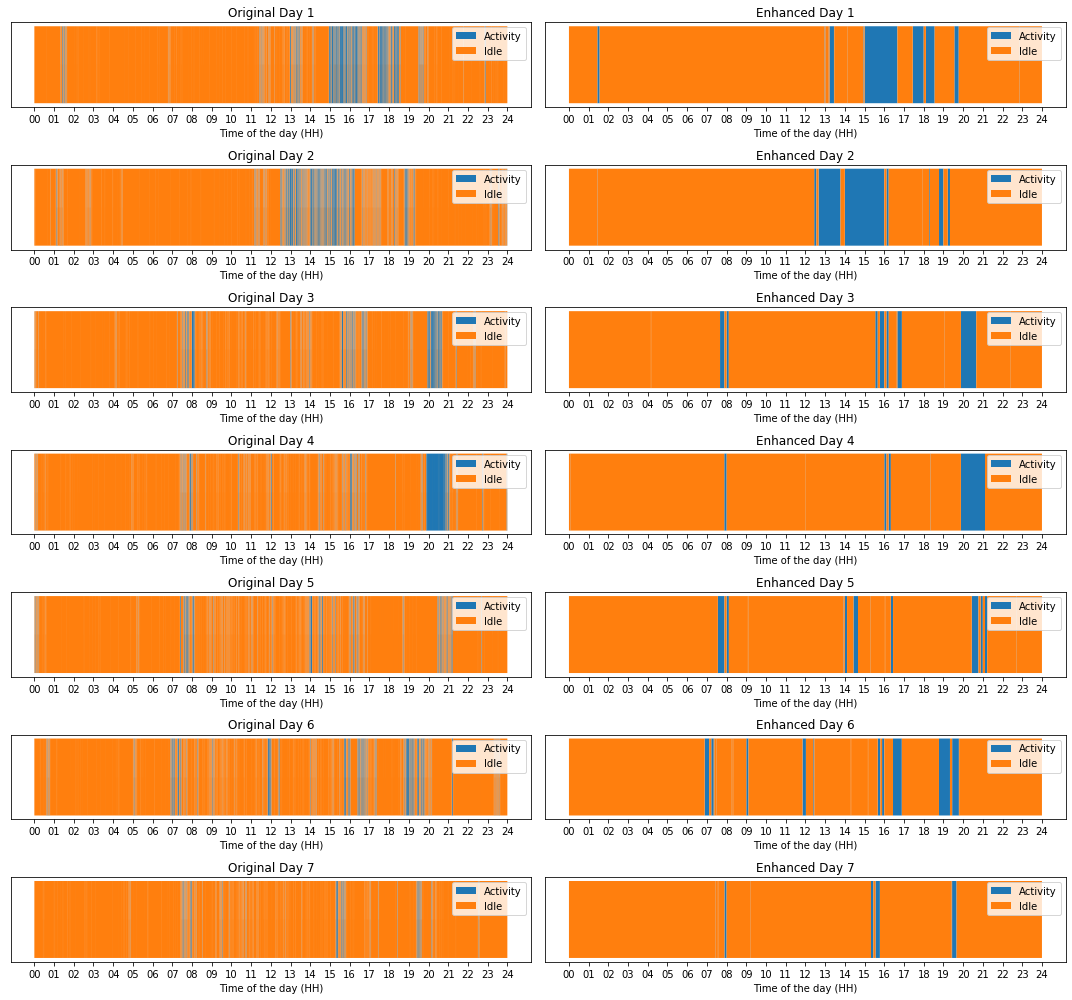

In [88]:
show_days(Z_daywise, thresh1=40, thresh0=100, window=400, threshold=200, n_iters=1, savename='./test_fig.pdf')